### Center of Neuroengineering and Therapeutics
# IEEG Pre-processing Pipeline
This notebook provides a recommended usage pipeline for the iEEG pre-processing toolkit.

## Imports



In [1]:
# set search path
import os,sys
import pandas as pd
import numpy as np

!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

!pip install git+https://github.com/haoershi/CNT_research_tools.git#subdirectory=python
from CNTtools import iEEGPreprocess

path = os.getcwd()

  Cloning https://github.com/ieeg-portal/ieegpy.git to /tmp/pip-req-build-g57r8zs2
  Running command git clone --filter=blob:none --quiet https://github.com/ieeg-portal/ieegpy.git /tmp/pip-req-build-g57r8zs2
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for ieeg: filename=ieeg-1.6-py3-none-any.whl size=27498 sha256=868333e0d89e33984fcbf9491d783bf42ae6b4853e317c35c705afd9fc460215
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9gtekr0/wheels/c0/2a/4d/452574b1c3c63e86df54de09161463c0509e9eeffc1aad898e
Successfully built ieeg
  Cloning https://github.com/haoershi/CNT_research_tools.git to /tmp/pip-req-build-_moqgnm4
  Running command git clone --filter=blob:none --quiet https://github.com/haoershi/CNT_research_tools.git /tmp/pip-req-build-_moqgnm4
  Resolved https://github.com/haoershi/CNT_rese

/usr/local/lib/python3.10/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Tuple[numpy.ndarray, dict] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(
/usr/local/lib/python3.10/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[str] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprec

## Pipeline implementation

In [4]:
#@title Initialize Session
#@markdown
#@markdown Initialize iEEGPreprocess session.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```session = iEEGPreprocess()```
session = iEEGPreprocess()

In [ ]:
#@title Login Configuration
#@markdown Set up iEEG.org login info for obtaining data
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```session.login_config()```
#@markdown
session.login_config()

### Available Methods
**Arguments:**
* datasets: diction of data objects
* meta: metadata as a pandas dataframe with columns | filename | start | stop | dura | fs |
* num_data: number of data objects available
* users: list of available iEEG login usernames
* user: dict, user information of the active account
* user_data_dir: str, default path to save user data

**Methods:**
* download_data: download data from ieeg.org
* list_data: list meta info
* remove_data: remove certain data instance
* load_data: load data from saved pickle files
* login: login with default or specified username
* login_config: input username and password info to create config files
* save: save session as pickle file

In [4]:
#@title
print('Arguments of class iEEGPreprocess:')
print([i for i in dir(session) if not callable(getattr(session, i)) and (not i.startswith('_'))])
print('Methods of class iEEGPreprocess:')
print([i for i in dir(session) if callable(getattr(session, i)) and (not i.startswith('_'))])

Arguments of class iEEGPreprocess:
['datasets', 'meta', 'num_data', 'user', 'user_data_dir']
Methods of class iEEGPreprocess:
['download_data', 'list_data', 'load_data', 'login', 'login_config', 'save']


In [6]:
#@title Get Data via Input
#@markdown Specify the filename, start/stop time, electrodes, etc.
iEEG_filename = "HUP172_phaseII"#@param {type:"string"}
start_time = 402580 #@param {type:"number"}
stop_time = 402600 #@param {type:"number"}
electrodes = "LE10, LE11, LH01, LH02, LH03, LH04" #@param {type:"string"}
electrodes = electrodes.split(', ')
# param = {'filename':iEEG_filename,
#          'start':start_time,
#          'stop':stop_time,
#          'electrodes':electrodes}

In [ ]:
#@title Get Data via File
#@markdown Specify the path to file containing data info (.csv/.tsv)
#@markdown Format Filename | Start time | Stop time | Electrodes
from CNTtools import settings
file_path = "getData_testInput.csv" # @param {type:"string"}
file_path = os.path.join(settings.TEST_DIR,file_path)
param = pd.read_csv(file_path)

#tmp fix
param = param.iloc[0,:3].to_dict()

In [13]:
#@title Download data
#@markdown Download data from ieeg.org.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data = session.download_data(filename, start_time, stop_time)```
data = session.download_data(iEEG_filename, start_time, stop_time)#, select_elecs = electrodes)
session.meta

,filename,start,stop,dura,fs
0,HUP172_phaseII,402580,402600,20,512.0
1,HUP172_phaseII,402580,402600,20,512.0


### Available Methods for Data Object
**Arguments:**
* filename/start/stop: inputs
* select_elects: selected channels for downloading
* ignore_elecs: channels excluded from downloading
* dura: duration of data segment
* data: active data array after pre-processing
* fs: sampling frequency
* ch_names: active channel names after pre-processing
* ref_chnames: channel names after re-referencing
* index: dataset index in current session
* conn: diction storing connectivity data
* history: operations done on data object
* raw: raw data array
* raw_chs: raw channel names
* username: ieeg username
* user_data_dir: str, default path to save user data
* nonieeg: boolean mask for non-intracranial channels
* bad: boolean mask for channels containing artifacts
* reject_details: reasons for identify bad channels

**Methods:**

Channels:
* clean_labels: standardize channel names
* find_nonieeg: identify non-iEEG channels
* find_bad_chs: identify bad channels containing artifacts
* reject_nonieeg: identify and remove non-iEEG channels
* reject_artifact: identify and remove artifact channels

Filtering:
* bandpass_filter: apply bandpass filter
* notch_filter: apply notch filter

Re-referencing:
* reref: re-referencing with chosen method
* car: common average re-referencing
* bipolar: bipolar re-referencing
* laplacian: laplacian re-referencing

Connectivity:
* connectivity: calculate various connectivity
* coherence: calculate coherence
* cross_corr: calculate cross correlation
* pearson: calculate pearson correlation
* plv: calculate phase-locking value
* relative_entropy: calculate relative entropy
* squared_pearson: calculate squared pearson correlation

Calculate features:
* bandpower: calculate bandpower
* line_length: calculate linelength

Plotting:
* plot: plot data
* conn_heatmap: plot connectivity matrix using heatmap

Others:
* load_locs: load electrode location information from .csv file
* pre_whiten: pre-whitening of iEEG data
* reverse: reverse operation by one step
* save: save session as pickle file

In [14]:
#@title Standardize channel names
#@markdown Convert channel names to standardized format
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.clean_labels()```
#@markdown
#@markdown Example changes:
#@markdown 'EKG01' -> 'EKG1'

# show cleaned and original labels
data.clean_labels()

In [15]:
#@title Identifiy Non-iEEG channels
#@markdown Find and return a boolean mask for Non-iEEG channels, 0 = iEEG, 1 = Non-iEEG
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.find_nonieeg()```
#@markdown ```data.nonieeg```

data.find_nonieeg()
print('Non-iEEG channels includes:')
print(data.ch_names[data.nonieeg])

Non-iEEG channels includes:
['EKG1' 'EKG2']


In [18]:
#@title Identifiy bad channels
#@markdown Find and return a boolean mask for bad channels (1 = bad channels), and details for reasons to reject.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.find_bad_chs()```
#@markdown ```data.bad, data.reject_details```

data.find_bad_chs()
print('Bad channels include:')
print(data.ch_names[data.bad])
#@markdown Details contain potential reasons for being a bad channel and corresponding channel indices.
print('\n')
print('Specific reasons for being rejected:')
for k,v in data.reject_details.items():
  print(k,data.ch_names[v])

Bad channels include:
['LB12' 'RE8' 'RE9' 'RE10']


Specific reasons for being rejected:
noisy ['LB12' 'RE8' 'RE9' 'RE10']
nans []
zeros []
var []
higher_std []
high_voltage []


In [21]:
#@title Clean data
#@markdown
#@markdown Reject Non-iEEG channels.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.reject_nonieeg()```
#@markdown
#@markdown Reject bad hannels containing artifacts
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.reject_artifact()```

data.reject_nonieeg()
data.reject_artifact()


In [22]:
#@title Filtering
#@markdown Filter iEEG signal with bandpass and notch filter.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```data.bandpass_filter(low_freq,high_freq)```
#@markdown
#@markdown ```data.notch_filter(notch_freq)```
#@markdown
#@markdown ```data.filter(low_freq,high_freq,notch_freq)```
low_freq = 1 # @param {type:"number"}
high_freq = 120 # @param {type:"number"}
notch_freq = 60 # @param {type:"number"}

data.bandpass_filter(low_freq,high_freq)
data.notch_filter(notch_freq)

ValueError: ignored

In [25]:
#@title Re-referencing
#@markdown Re-reference data to a different montage
#@markdown
#@markdown Available options:
#@markdown * Common Average Re-referencing (CAR)
#@markdown * Bipolar Re-referencing (BR)
#@markdown * Laplacian Re-referencing (LAR): Note, requires location of electrodes and radius threshold
#@markdown
#@markdown Suggested syntax:
#@markdown * CAR: ```data.car()```
#@markdown * BR: ```data.bipolar()```
#@markdown * LAR: ```data.laplacian(loc_file)```
#@markdown * ```data.reref(method)```

ref = "BR" # @param ["CAR", "BR", "LAR"]
loc_file = 'elec_locs.csv' # @param {type:"string"}
radius = 20 # @param {type:"number"}

if ref == 'CAR':
  data.car()
elif ref == 'BR':
  data.bipolar()
elif ref == 'LAR':
  data.laplacian(locs = loc_file,radius=radius)

AttributeError: ignored

In [24]:
data.reverse()

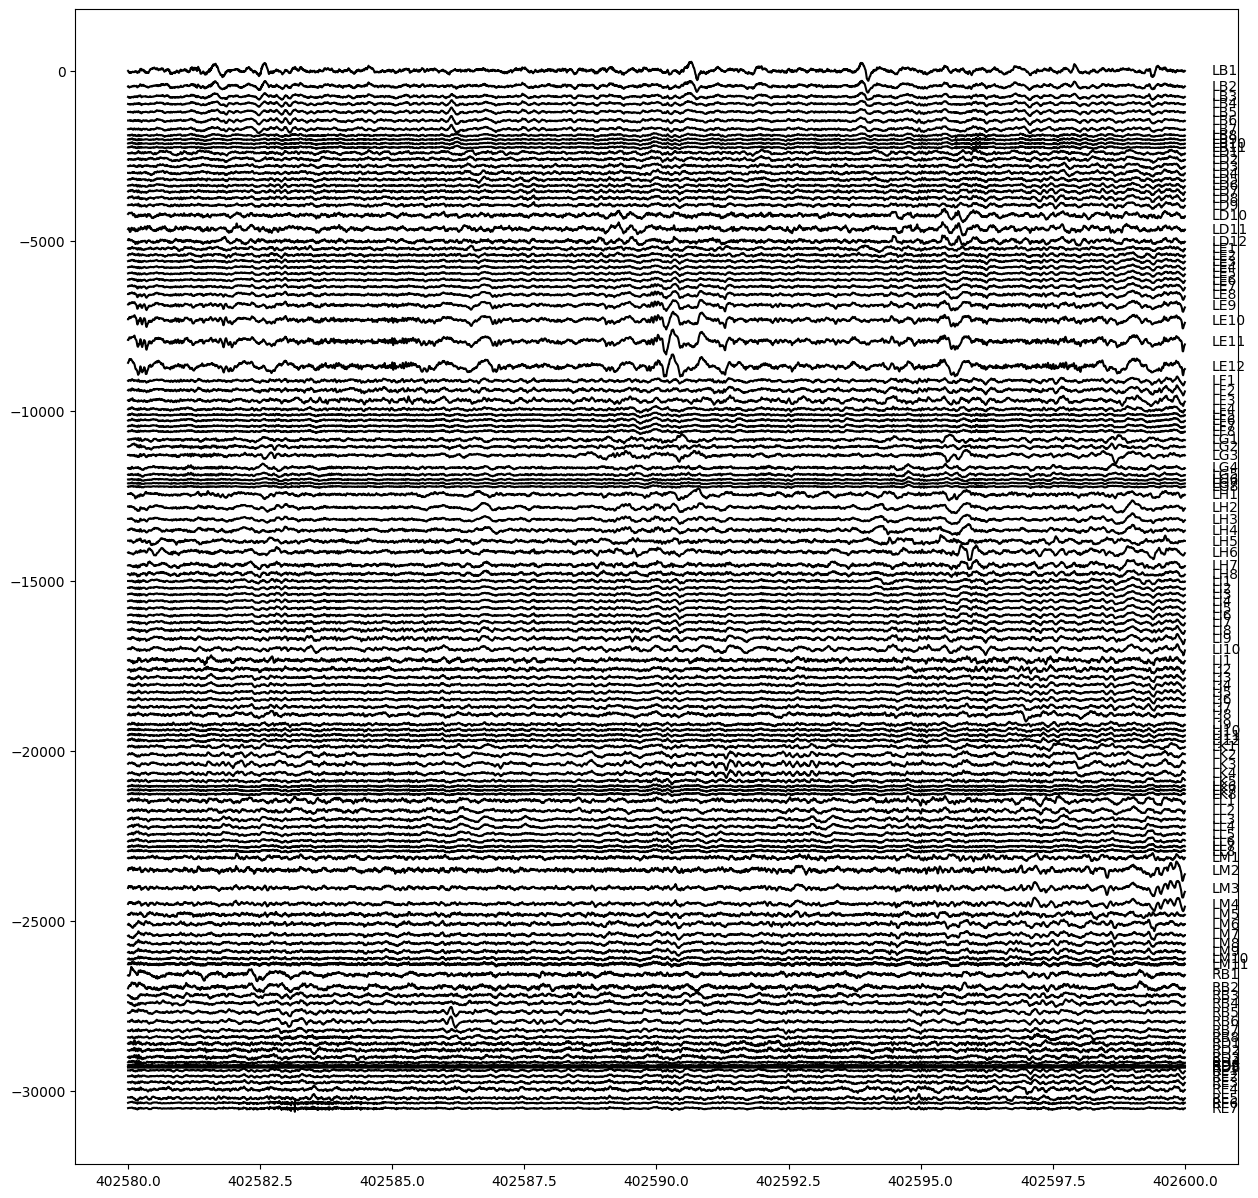

In [26]:
#@title Plot data
#@markdown Generate plot of time-series data
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```fig = data.plot()```
fig = data.plot()

In [41]:
#@title Connectivity Analysis
#@markdown Connectivity analysis using various methods.
#@markdown
#@markdown Available options:
#@markdown * Pearson Correlation:  ```data.pearson()```
#@markdown * Squared Pearson:  ```data.squared_pearson()```
#@markdown * Cross Correlation:  ```data.cross_corr()```
#@markdown * Coherence:  ```data.coh()```
#@markdown * Phase-Locking Value (PLV):  ```data.plv()```
#@markdown * Relative Entropy:  ```data.relative_entropy()```
#@markdown
#@markdown Optional syntax:
#@markdown
#@markdown ```data.connectivity(method_list)```

conn_method = "squared_pearson" # @param ["pearson", "squared_pearson", "cross_corr", "coh", "plv", "rela_entropy"]

data.connectivity([conn_method])

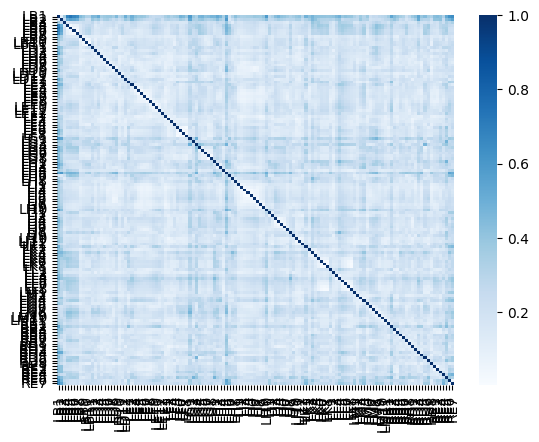

<Axes: >

In [42]:
#@title Connectivity heatmap
#@markdown Heatmap plot of calculated connectivity matrix.
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```fig = data.conn_heatmap(method,frequency)```

conn_method = "rela_entropy" # @param ["pearson", "squared_pearson", "cross_corr", "coh", "plv", "rela_entropy"]
freq_band = "broad" # @param ['delta','theta','alpha','beta','gamma','ripple','broad']
data.conn_heatmap(conn_method,freq_band)

In [43]:
#@title Save data
#@markdown Save data in pickle format
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```session.save(filename)```
#@markdown
#@markdown ```data.save()```

filename = 'session0'  #@param {type:"string"}
session.save(filename)
data.save()

In [44]:
#@title Load data
#@markdown Load saved pickle format data
#@markdown
#@markdown Suggested syntax:
#@markdown
#@markdown ```session.load_data(dir)```
#@markdown
#@markdown ```session.load_data(filename)```
session.load_data('')
session.list_data()

         filename   start    stop  dura     fs
0  HUP172_phaseII  402580  402600    20  512.0
1  HUP172_phaseII  402580  402600    20  512.0
2  HUP172_phaseII  402580  402600    20  512.0
3  HUP172_phaseII  402580  402600    20  512.0
4  HUP172_phaseII  402580  402600    20  512.0


## Batch Processing
Code for parallel processing of multiple data files

In [ ]:
#@title Settings
#@markdown Get Data via File:
#@markdown
#@markdown Specify the path to file containing data info (.csv/.tsv)
#@markdown Format Filename | Start time | Stop time | Electrodes
file_path = "test/getData_testInput.csv" # @param {type:"string"}

#@markdown Filtering Settings:

low_freq = 1 # @param {type:"number"}
high_freq = 120 # @param {type:"number"}
notch_freq = 60 # @param {type:"number"}

#@markdown Re-ref method Setting:
ref = "CAR" # @param ["CAR", "BR", "LAR"]
#@markdown Laplacian Setting:
loc_file = 'elec_locs.csv' # @param {type:"string"}
radius = 20 # @param {type:"number"}

#@markdown Connectivity Setting:
conn_method = "pearson" # @param ["pearson", "squared_pearson", "cross_corr", "coh", "plv", "relative_entropy"]

#@markdown Save data:
save = True # @param {type:"boolean"}

In [ ]:
#@title Implementation

param = pd.read_csv(file_path)
param = param.iloc[:2,:3]
param_dict = []
for i in range(param.shape[0]):
  param_dict.append(param.iloc[i,:].to_dict())
session = iEEGPreprocess()
session.login()
for i in range(len(param_dict)):
  param = param_dict[i]
  data = session.download_data(param['filename'], param['start'], param['stop'])
  data.clean_labels()
  data.reject_nonieeg()
  data.reject_artifact()
  data.filter(low_freq,high_freq,notch_freq)
  data.reref(ref,locs=loc_file,radius=radius)
  data.connectivity([conn_method])
  if save:
    data.save()



# add save figure
# add full settings for batch processing